In [306]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [307]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark= False

In [308]:
m = 500                            # 5, 50, 100, 500 , 1000 , 2000 

In [309]:
desired_num = 10000

In [310]:
tr_i = 0
tr_j = desired_num
tr_k = desired_num+1000

tr_i, tr_j, tr_k

(0, 10000, 11000)

# Generate dataset

In [311]:
np.random.seed(12)
y = np.random.randint(0,3,500)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 174
1 163
2 163


In [312]:
x = np.zeros((500,))

In [313]:
np.random.seed(12)
x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))

In [314]:
x[idx[0]][0], x[idx[2]][5] 

(-0.8458371576203276, 2.2459800877058114)

In [315]:
print(x.shape,y.shape)

(500,) (500,)


In [316]:
idx= []
for i in range(3):
  idx.append(y==i)

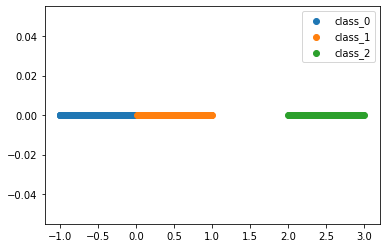

In [317]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [318]:
bg_idx = [ np.where(idx[2] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(163,)

In [319]:
np.unique(bg_idx).shape

(163,)

In [320]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [321]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([-1.00805526e-16]), array([-1.7163962]))

In [322]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [323]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([1.]), array([4.37808847]))

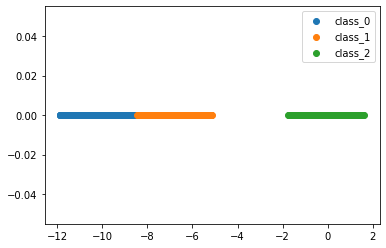

In [324]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [325]:
foreground_classes = {'class_0','class_1' }

background_classes = {'class_2'}

In [326]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,m)

a = []
for i in range(m):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,3)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 2 present at 0
background 2 present at 1
background 2 present at 2
background 2 present at 3
background 2 present at 4
background 2 present at 5
background 2 present at 6
background 2 present at 7
background 2 present at 8
background 2 present at 9
background 2 present at 10
background 2 present at 11
background 2 present at 12
background 2 present at 13
background 2 present at 14
background 2 present at 15
background 2 present at 16
background 2 present at 17
background 2 present at 18
background 2 present at 19
background 2 present at 20
background 2 present at 21
background 2 present at 22
background 2 present at 23
background 2 present at 24
background 2 present at 25
background 2 present at 26
background 2 present at 27
background 2 present at 28
background 2 present at 29
background 2 present at 30
background 2 present at 31
background 2 present at 32
background 2 present at 33
background 2 present at 34
background 2 present at 35
background 2 present at 36
background 

In [327]:
a.shape

(500,)

In [328]:
np.reshape(a,(m,1))

array([[-0.80241043],
       [ 1.00228507],
       [-0.81132988],
       [ 1.2774409 ],
       [ 0.57398646],
       [-0.91850331],
       [ 0.6600648 ],
       [ 0.57398646],
       [ 1.39799803],
       [ 0.13695373],
       [-1.44264034],
       [ 0.71837826],
       [ 1.08544127],
       [ 1.55171236],
       [ 0.4152144 ],
       [-1.15692643],
       [-1.62776348],
       [ 0.65339431],
       [ 0.44998336],
       [-1.35067387],
       [-0.1541663 ],
       [ 1.2774409 ],
       [ 0.44998336],
       [ 1.20061574],
       [-0.83952364],
       [ 0.46279645],
       [-0.90487837],
       [ 0.8325454 ],
       [-0.41161127],
       [-0.94524964],
       [-0.2407784 ],
       [ 0.80282356],
       [ 0.18678022],
       [ 0.41553291],
       [ 0.99304358],
       [-0.94524964],
       [-1.44264034],
       [-1.36429042],
       [-0.36474865],
       [ 0.1392267 ],
       [ 0.1428216 ],
       [-1.08085196],
       [ 0.6600648 ],
       [-1.17697967],
       [-0.29918788],
       [-1

In [329]:
from tqdm import tqdm
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num+1000)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,2)
    fg_idx = 0
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)
    # if(j%(int(desired_num/4))==0):
      # print("25% done")

100%|██████████| 11000/11000 [06:25<00:00, 28.54it/s]


In [330]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T
mosaic_list_of_images.shape

(11000, 500)

In [331]:
np.sum(mosaic_list_of_images[0:tr_j], axis=1).shape, np.sum(mosaic_list_of_images[0:tr_j], axis=1)

((10000,), array([-10.21806515, -10.79146525,  -9.47009026, ..., -10.91181212,
          6.4640813 , -43.54256649]))

In [332]:
train = np.sum(mosaic_list_of_images[0:tr_j], axis=1)/m
train[0], train.shape

(-0.02043613029758322, (10000,))

In [333]:
test = mosaic_list_of_images[tr_j:tr_k,0]/m
test[0], test.shape

(-0.023585400912882814, (1000,))

In [334]:
avg_image_dataset_1 , labels_1,  fg_index_1 = np.sum(mosaic_list_of_images[0:tr_j], axis=1)/m , mosaic_label[0:tr_j], fore_idx[0:tr_j] 


test_dataset , labels , fg_index = mosaic_list_of_images[tr_j:tr_k,0]/m , mosaic_label[tr_j : tr_k], fore_idx[tr_j : tr_k] 

In [335]:
avg_image_dataset_1[0], test_dataset[0], avg_image_dataset_1.shape, test_dataset.shape

(-0.02043613029758322, -0.023585400912882814, (10000,), (1000,))

In [355]:
avg_image_dataset_1 = avg_image_dataset_1.reshape(desired_num,1)
test_dataset = test_dataset.reshape(1000, 1)
avg_image_dataset_1.shape, test_dataset.shape

((10000, 1), (1000, 1))

In [356]:
# avg_image_dataset_1 = torch.stack(avg_image_dataset_1, axis = 0)

# mean = torch.mean(avg_image_dataset_1, keepdims= True, axis = 0)
# std = torch.std(avg_image_dataset_1, keepdims= True, axis = 0)

# avg_image_dataset_1 = (avg_image_dataset_1 - mean) / std 

# print(torch.mean(avg_image_dataset_1, keepdims= True, axis = 0))
# print(torch.std(avg_image_dataset_1, keepdims= True, axis = 0))
# print("=="*40)


# test_dataset = torch.stack(test_dataset, axis = 0)
# mean = torch.mean(test_dataset, keepdims= True, axis = 0)
# std = torch.std(test_dataset, keepdims= True, axis = 0)
# test_dataset = (test_dataset - mean) / std

# print(torch.mean(test_dataset, keepdims= True, axis = 0))
# print(torch.std(test_dataset, keepdims= True, axis = 0))
# print("=="*40)


Text(0.5, 1.0, 'dataset1 CIN with alpha = 1/500')

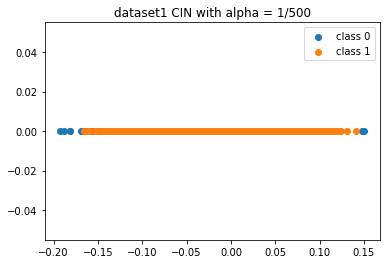

In [357]:
x1 = (avg_image_dataset_1)
y1 = np.array(labels_1)

# idx1 = []
# for i in range(3):
#   idx1.append(y1 == i)

# for i in range(3):
#     z = np.zeros(x1[idx1[i]].shape[0])
#     plt.scatter(x1[idx1[i]],z,label="class_"+str(i))
# plt.legend()

plt.scatter(x1[y1==0], y1[y1==0]*0, label='class 0')
plt.scatter(x1[y1==1], y1[y1==1]*0, label='class 1')
# plt.scatter(x1[y1==2], y1[y1==2]*0, label='class 2')
plt.legend()
plt.title("dataset1 CIN with alpha = 1/"+str(m))

Text(0.5, 0, 'X')

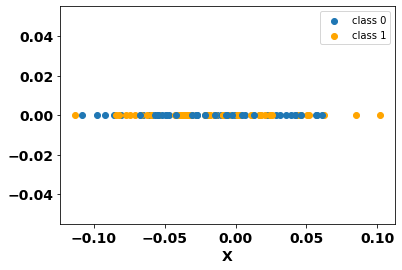

In [358]:
x1 = (avg_image_dataset_1)
y1 = np.array(labels_1)

idx_1 = y1==0
idx_2 = np.where(idx_1==True)[0]
idx_3 = np.where(idx_1==False)[0]
color = ['#1F77B4','orange', 'brown']

true_point = len(idx_2)
plt.scatter(x1[idx_2[:25]], y1[idx_2[:25]]*0, label='class 0', c= color[0], marker='o')
plt.scatter(x1[idx_3[:25]], y1[idx_3[:25]]*0, label='class 1', c= color[1], marker='o')

plt.scatter(x1[idx_3[50:75]], y1[idx_3[50:75]]*0,  c= color[1], marker='o')
plt.scatter(x1[idx_2[50:75]], y1[idx_2[50:75]]*0,  c= color[0], marker='o')


plt.legend()
plt.xticks( fontsize=14, fontweight = 'bold')
plt.yticks( fontsize=14, fontweight = 'bold')
plt.xlabel("X", fontsize=14, fontweight = 'bold')
# plt.savefig(fp_cin+"ds1_alpha_04.png", bbox_inches="tight")
# plt.savefig(fp_cin+"ds1_alpha_04.pdf", bbox_inches="tight")

In [359]:
avg_image_dataset_1[0:10]

array([[-0.02043613],
       [-0.02158293],
       [-0.01894018],
       [-0.08562688],
       [-0.03473192],
       [ 0.01673077],
       [-0.00041908],
       [-0.01507021],
       [-0.07714583],
       [-0.04686793]])

Text(0.5, 1.0, 'test dataset1 ')

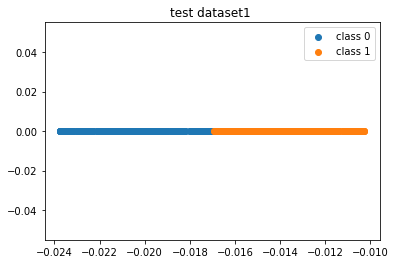

In [360]:
x1 = (test_dataset)
y1 = np.array(labels)

# idx1 = []
# for i in range(3):
#   idx1.append(y1 == i)

# for i in range(3):
#     z = np.zeros(x1[idx1[i]].shape[0])
#     plt.scatter(x1[idx1[i]],z,label="class_"+str(i))
# plt.legend()

plt.scatter(x1[y1==0], y1[y1==0]*0, label='class 0')
plt.scatter(x1[y1==1], y1[y1==1]*0, label='class 1')
# plt.scatter(x1[y1==2], y1[y1==2]*0, label='class 2')
plt.legend()
plt.title("test dataset1 ")

In [361]:
test_dataset[0:10]

array([[-0.0235854 ],
       [-0.01333246],
       [-0.01630295],
       [-0.01382226],
       [-0.01667354],
       [-0.02240826],
       [-0.01845833],
       [-0.02065663],
       [-0.01197566],
       [-0.01692468]])

In [362]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [363]:
avg_image_dataset_1[0].shape, avg_image_dataset_1[0]

((1,), array([-0.02043613]))

In [364]:
batch = 200

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [365]:
testdata_1 = MosaicDataset(test_dataset, labels )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

In [366]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(1,2)
        # self.linear2 = nn.Linear(50,10)
        # self.linear3 = nn.Linear(10,3)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)

    def forward(self,x):
        # x = F.relu(self.linear1(x))
        # x = F.relu(self.linear2(x))
        x = (self.linear1(x))

        return x

In [367]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [368]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [369]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=0.0001 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1500
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi, net
    

In [370]:
train_loss_all=[]

testloader_list= [ testloader_1 ]

In [371]:
loss, net = train_all(trainloader_1, 1, testloader_list)
train_loss_all.append(loss)

--------------------------------------------------------------------------------
training on data set   1
epoch: [0 ] loss: 0.692
epoch: [1] loss: 0.692
epoch: [201] loss: 0.691
epoch: [401] loss: 0.690
epoch: [601] loss: 0.690
epoch: [801] loss: 0.690
epoch: [1001] loss: 0.690
epoch: [1201] loss: 0.690
epoch: [1401] loss: 0.690
Finished Training
Accuracy of the network on the 10000 train images: 53.26 %
unique out:  [0 1] unique pred:  [0 1]
correct:  921 total  1000
Accuracy of the network on the 1000 test dataset 1: 92.10 %
--------------------------------------------------------------------------------


In [353]:
net.linear1.weight, net.linear1.bias

(Parameter containing:
 tensor([[-1.6036],
         [ 1.9277]], device='cuda:0', dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([-0.0319,  0.0319], device='cuda:0', dtype=torch.float64,
        requires_grad=True))

In [354]:
%matplotlib inline

In [ ]:
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))